# PC Session 4

**Author:**
[Helge Liebert](https://hliebert.github.io/)

## Model inputs

In [1]:
# generate random data in which y is a noisy function of x
x1 <- runif(1000, -5, 5)
x2 <- runif(1000, -15, 15)
x3 <- runif(1000, -1, 7)
intercept <- rep(1, 1000)

In [2]:
## Outcome and matrix of regressors plus intercept, univariate case
y <- x1 + rnorm(1000) + 3
X <- as.matrix(cbind(intercept, x1))

In [3]:
## Outcome and matrix of regressors plus intercept, multivariate case
## y <- 3*x1 + 0.5*x2 + 15*x3  + rnorm(1000) + 3
## X <- as.matrix(cbind(intercept, x1, x2, x3))

In [4]:
length(y)
dim(X)
cbind(X,y)

[1] 1000

[1] 1000    2

intercept,x1,y
1,0.80279476,3.8190551
1,-1.14773722,1.9935917
1,1.83735800,4.6977552
1,-0.05350421,2.5378688
1,-1.81734750,-0.5370362
1,1.16676122,5.8670196
1,1.90916875,5.2074431
1,-3.02998380,1.1638778
1,4.90464277,8.5774350
1,-4.50976737,-0.6069926


## Different ways of computing linear regression

### Linear regression by solving normal equations

In [5]:
## Using matrices to solve the system of equations, (X'X)^-1 X'y
b.ols <- solve(t(X) %*% X) %*% t(X) %*% y
b.ols 

intercept,2.998082
x1,1.000038


In [6]:
# more idiomatic
b.ols <- solve(crossprod(X), crossprod(X,y))
b.ols

intercept,2.998082
x1,1.000038


### Linear regression by QR-decomposition

In [7]:
## Fit a linear model, QR-decomposition/Gram-Schmidt orthogonalization
b.qrd <- lm(y ~ X - 1)
b.qrd


Call:
lm(formula = y ~ X - 1)

Coefficients:
Xintercept         Xx1  
     2.998       1.000  


In [8]:
## Doing qrd manually and solving
qrdecomp <- qr(X)
b.qrd <- as.matrix(backsolve(qrdecomp$qr, qr.qty(qrdecomp, y)))
b.qrd

2.998082
1.000038


### Linear regression by SVD

In [9]:
svdecomp <- svd(X)
str(svdecomp)

List of 3
 $ d: num [1:2] 89.7 31.6
 $ u: num [1:1000, 1:2] 0.009187 -0.012554 0.020719 -0.000358 -0.020018 ...
 $ v: num [1:2, 1:2] 0.0214 0.9998 0.9998 -0.0214


In [10]:
## computing A^{+}y, (X'X)^{-1}X' is Moore-Penrose Pseudoinverse, optained via SVD, 
b.svd <- svdecomp$v %*% solve(diag(svdecomp$d)) %*% t(svdecomp$u) %*% y
b.svd

2.998082
1.000038


In [11]:
## function for Moore-Penrose Pseudoinverse
b.svd <- MASS::ginv(X) %*% y
b.svd

2.998082
1.000038


In [12]:
## Moore-penrose Pseudoinverse, computed via eigenvalue decomposition of x'x
egd <- eigen(t(X) %*% X)
xtx.inv <- egd$vectors %*% solve(diag(egd$values)) %*% t(egd$vectors)
x.pseudo.inv <- xtx.inv %*% t(X)
b.svd <- x.pseudo.inv %*% y
b.svd

2.998082
1.000038


### Gradient descent

In [13]:
## squared error cost function
cost <- function(X, y, theta) {
  sum((X %*% theta - y)^2) / (2 * length(y))
}

## euclidean norm
eucnorm <- function(x) sqrt(sum(x^2))

#### Batch gradient descent

Simple approach, fixed # of iterations

In [14]:
## initialize coefficients
theta <- matrix(c(0, 0), nrow = 2) ## univariate
## theta <- matrix(c(0, 0), nrow = 4) ## multivariate

In [15]:
## learning rate and iteration limit
alpha <- 0.01
niter <- 2000

In [16]:
## keep history
cost_history <- double(niter)
theta_history <- list(niter)

In [17]:
## compute gradient and update
set.seed(42)
for (i in 1:niter) {
  error <- (X %*% theta) - y
  delta <- t(X) %*% error / length(y)
  theta <- theta - alpha * delta
  cost_history[i] <- cost(X, y, theta)
  theta_history[[i]] <- theta
  ## if ((i %% 100) == 0) print(theta)
}
print(theta)
print(niter)

              [,1]
intercept 2.998082
x1        1.000038
[1] 2000


#### Batch gradient descent

With a stopping rule instead of a fixed number of iterations

In [18]:
## initialize coefficients
theta <- matrix(c(0, 0), nrow = 2) ## univariate
## theta <- matrix(c(0, 0), nrow = 4) ## multivariate

In [19]:
## keep history
cost_history <- c()
theta_history <- list()

In [20]:
## stopping threshold
epsilon <- 10e-10
delta <- Inf
i = 0

In [21]:
## compute gradient and update
## threshold and first iteration values
set.seed(42)
while (eucnorm(delta) > epsilon) {
  error <- (X %*% theta) - y
  delta <- t(X) %*% error / length(y)
  theta <- theta - alpha * delta
  cost_history <- c(cost_history, cost(X, y, theta))
  theta_history <- append(theta_history, list(theta))
  ## if ((i %% 100) == 0) print(theta)
  i <- i + 1
}
print(theta)
print(i)

              [,1]
intercept 2.998082
x1        1.000038
[1] 2179


#### Compare estimates

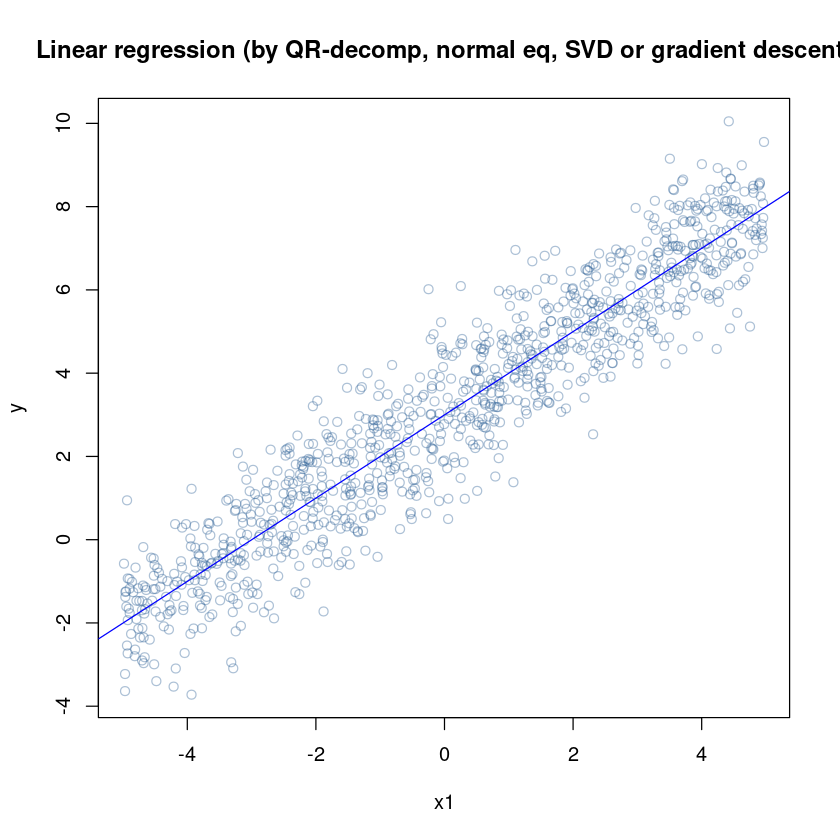

In [22]:
## compare estimates
plot(x1, y, col = rgb(0.2, 0.4, 0.6, 0.4), 
     main = "Linear regression (by QR-decomp, normal eq, SVD or gradient descent)")
abline(b.qrd[1:2], col = "blue")
#abline(b.ols[1:2], col = "green")
#abline(b.svd[1:2], col = "red")
#abline(theta[1:2], col = "pink")

#### Converging fit

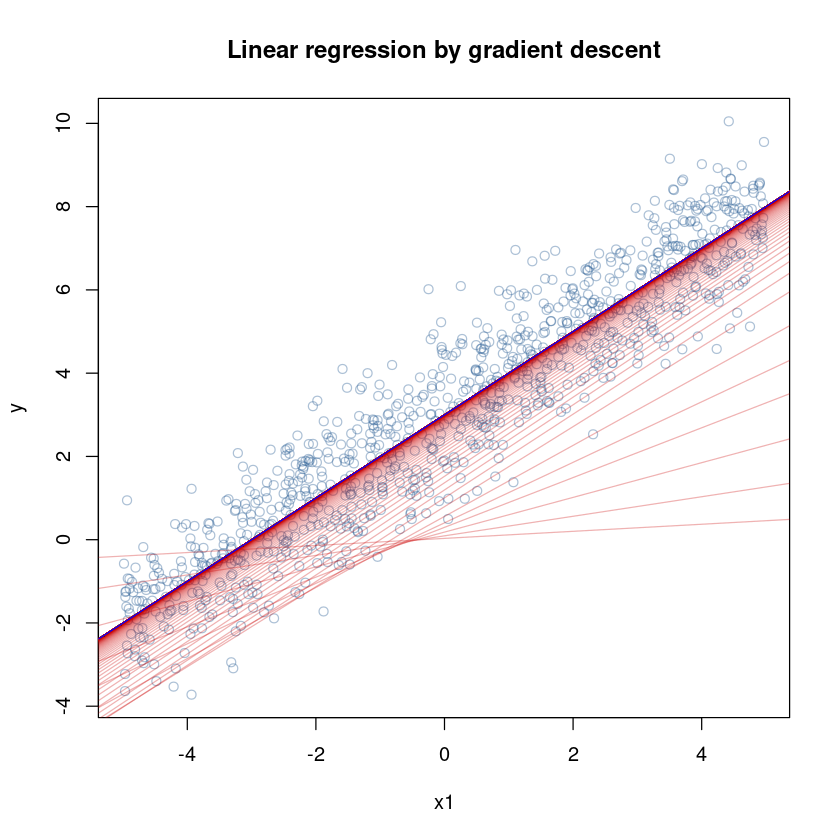

In [23]:
## plot data and converging fit
plot(x1, y, col = rgb(0.2, 0.4, 0.6, 0.4),
     main = "Linear regression by gradient descent")
for (i in c(1, 3, 6, 10, 14, seq(20, niter, by = 10))) {
  abline(coef = theta_history[[i]], col = rgb(0.8, 0, 0, 0.3))
}
abline(coef = theta, col = "blue")

#### Cost function

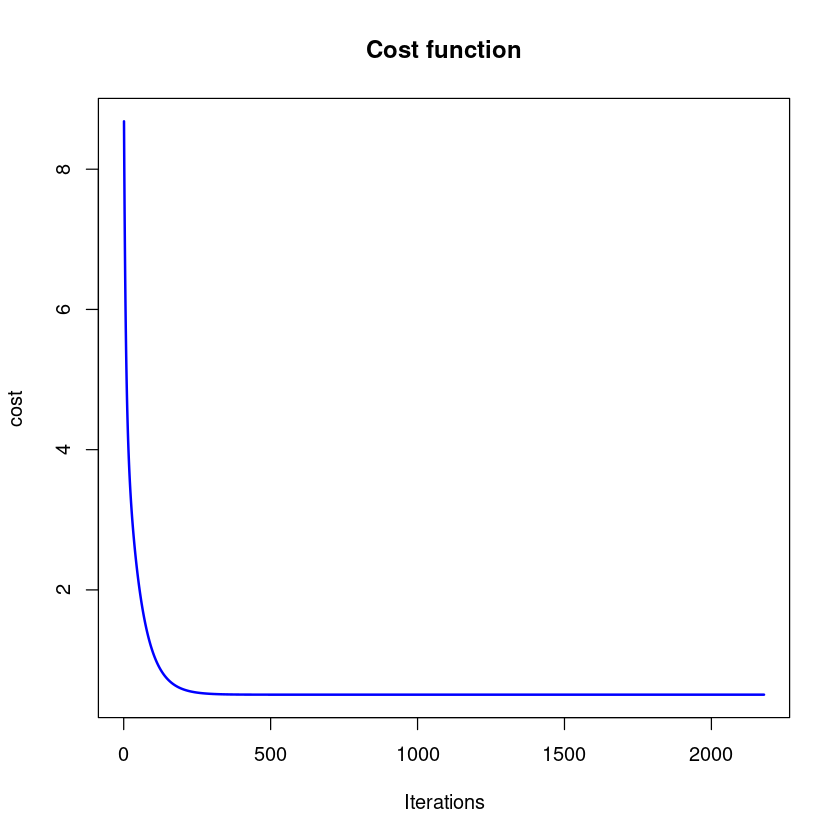

In [24]:
## cost convergence
plot(cost_history, type = "l", col = "blue", lwd = 2,
     main = "Cost function", ylab = "cost", xlab = "Iterations")

In [25]:
conv <- as.data.frame(cbind(t(sapply(theta_history, function(x) x[, 1])), cost = cost_history))
head(conv, 30)

,intercept,x1,cost
,<dbl>,<dbl>,<dbl>
1,0.03148926,0.08494411,8.682736
2,0.06253550,0.16300962,8.002278
3,0.09315353,0.23475037,7.415353
4,0.12335716,0.30067563,6.907746
5,0.15315932,0.36125369,6.467431
6,0.18257208,0.41691519,6.084236
7,0.21160675,0.46805609,5.749558
8,0.24027394,0.51504051,5.456114
9,0.26858358,0.55820325,5.197744


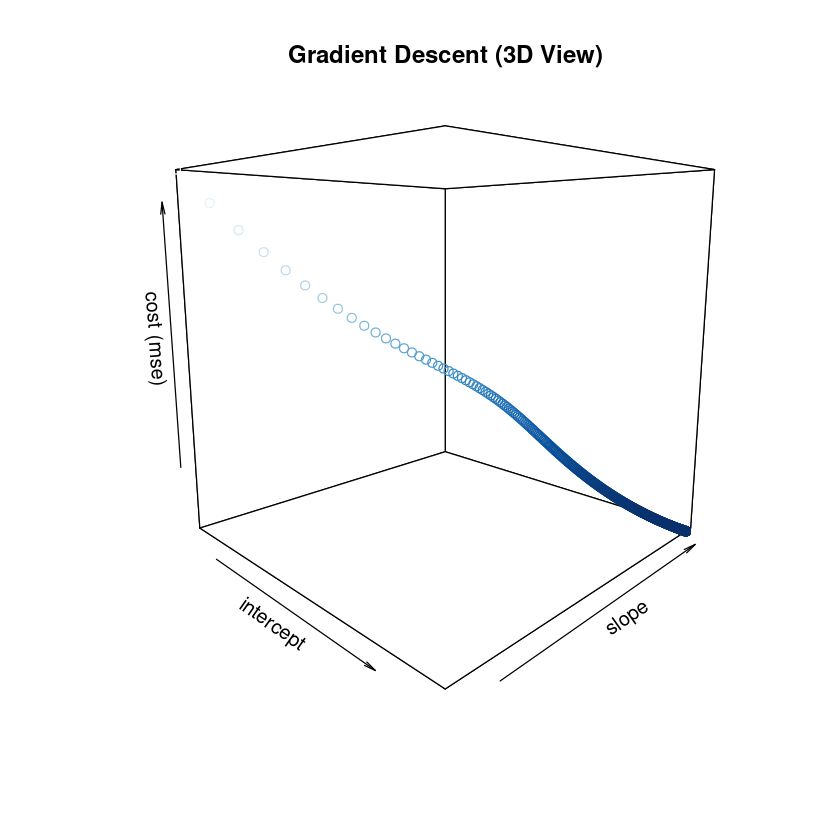

In [27]:
library("plot3D")
scatter3D(
  x = conv$intercept,
  y = conv$x1,
  z = conv$cost,
  xlab = "intercept",
  ylab = "slope",
  zlab = "cost (mse)",
  col = ramp.col(
    col = sort(RColorBrewer::brewer.pal(9, "Blues"), decreasing = F),
    n = length(unique(conv$cost))
  ),
  colkey = F,
  phi = 10,
  theta = 45,
  main = "Gradient Descent (3D View)"
)

### Stochastic gradient descent, single obs 

In [28]:
theta <- matrix(c(0, 0), nrow = 2) ## univariate
## theta <- matrix(c(0, 0), nrow = 4) ## multivariate
cost_history <- c()
theta_history <- list()
set.seed(42)
for (i in 1:niter) {
  j <- sample(NROW(X), 1)
  error <- (X[j, ] %*% theta) - y[j]
  delta <- X[j, ] %*% error / length(y[j])
  theta <- theta - alpha * delta
  cost_history[i] <- cost(X[j, ], y[j], theta) ## cost function could be simplified
  theta_history[[i]] <- theta
}
print(theta)

          [,1]
[1,] 2.9762407
[2,] 0.9087277


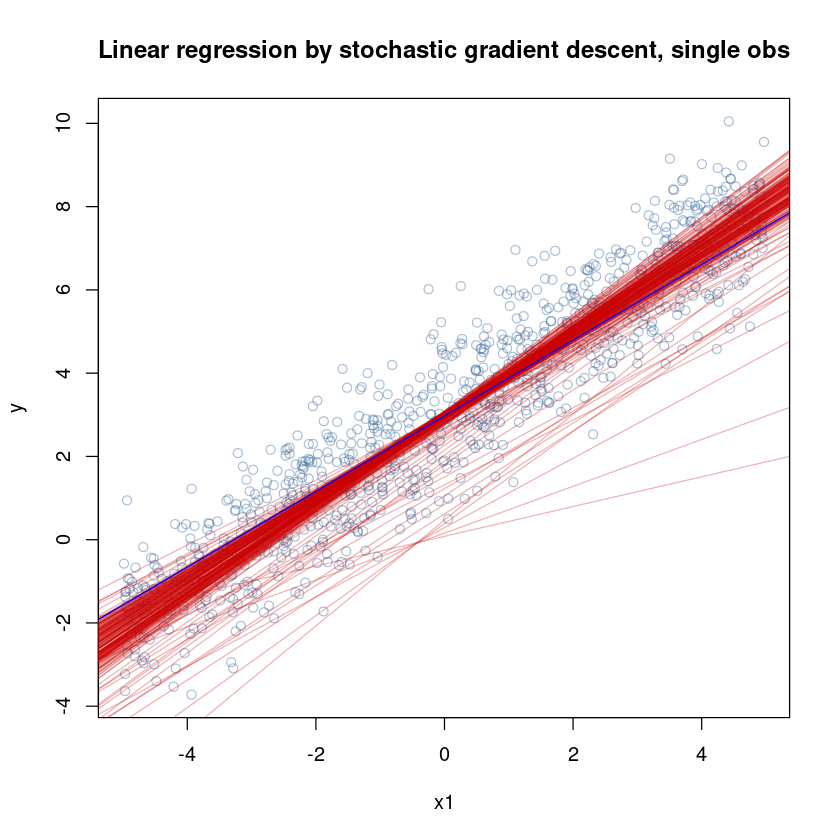

In [29]:
## plot data and converging fit
plot(x1, y, col = rgb(0.2, 0.4, 0.6, 0.4),
     main = "Linear regression by stochastic gradient descent, single obs")
for (i in c(1, 3, 6, 10, 14, seq(20, niter, by = 10))) {
  abline(coef = theta_history[[i]], col = rgb(0.8, 0, 0, 0.3))
}
abline(coef = theta, col = "blue")

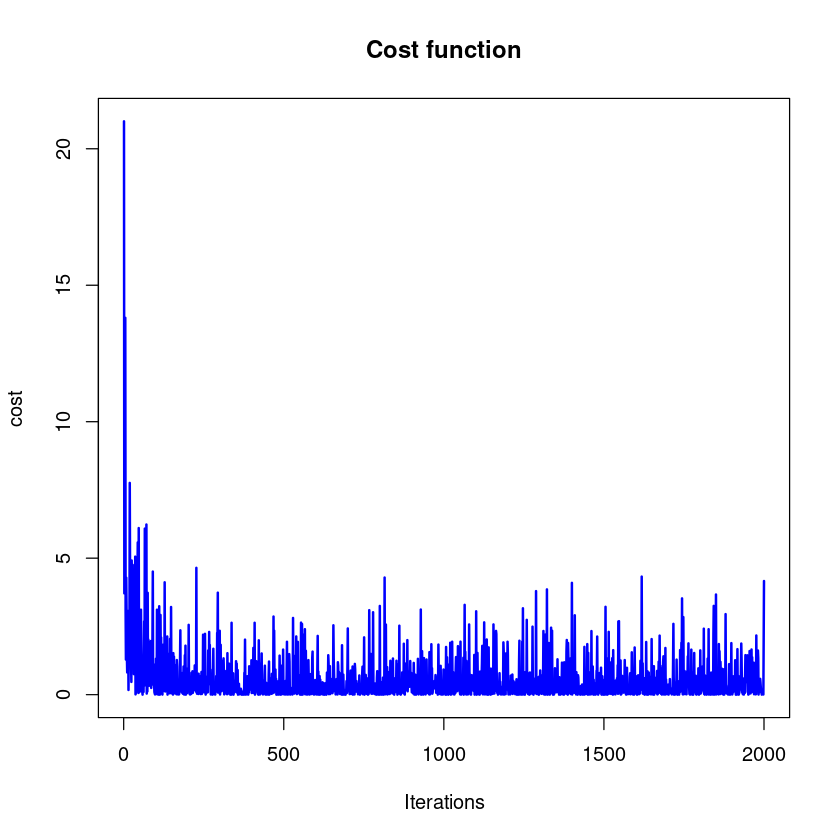

In [30]:
## cost convergence
plot(cost_history, type = "l", col = "blue", lwd = 2,
     main = "Cost function", ylab = "cost", xlab = "Iterations")

In [36]:
conv <- as.data.frame(cbind(t(sapply(theta_history, function(x) x[, 1])), cost = cost_history))
head(conv, 30)
names(conv) <- c("intercept", "x1", "cost")                                    

,V1,V2,cost
,<dbl>,<dbl>,<dbl>
1,0.08134637,0.3575718,21.0050694
2,0.10910418,0.3320962,3.7118366
3,0.15782835,0.5624149,6.9750352
4,0.21037317,0.7805783,9.2283768
5,0.26447243,0.8544680,13.8070270
6,0.28976822,0.8335039,3.0923580
7,0.30600515,0.8407202,1.2868074
8,0.33795351,0.9273202,4.2870241
9,0.36470237,0.9996717,3.0072258


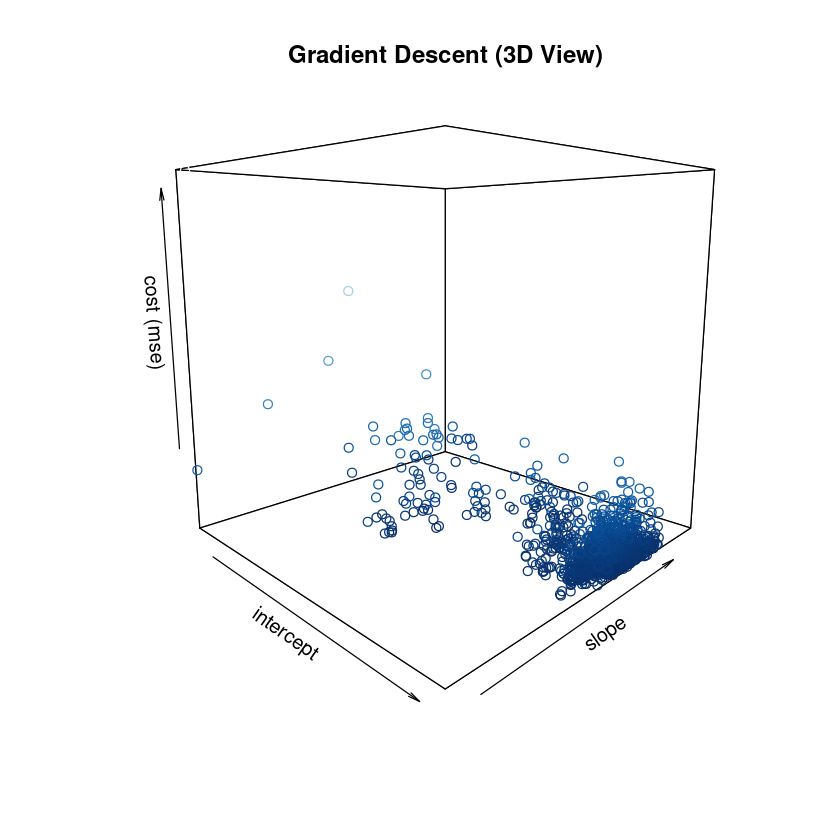

In [37]:
library(plot3D)
scatter3D(
  x = conv$intercept,
  y = conv$x1,
  z = conv$cost,
  xlab = "intercept",
  ylab = "slope",
  zlab = "cost (mse)",
  col = ramp.col(
    col = sort(RColorBrewer::brewer.pal(9, "Blues"), decreasing = F),
    n = length(unique(conv$cost))
  ),
  colkey = F,
  phi = 10,
  theta = 45,
  main = "Gradient Descent (3D View)"
)

### Stochastic gradient descent, single batch 

In [38]:
theta <- matrix(c(0, 0), nrow = 2) ## univariate
## theta <- matrix(c(0, 0), nrow = 4) ## multivariate
cost_history <- c()
theta_history <- list()
set.seed(42)
for (i in 1:niter) {
  select <- sample(NROW(X), 32)
  error <- (X[select, ] %*% theta) - y[select]
  delta <- t(X[select, ]) %*% error / length(y[select])
  theta <- theta - alpha * delta
  cost_history[i] <- cost(X[select, ], y[select], theta)
  theta_history[[i]] <- theta
}
print(theta)

               [,1]
intercept 3.0094348
x1        0.9915239


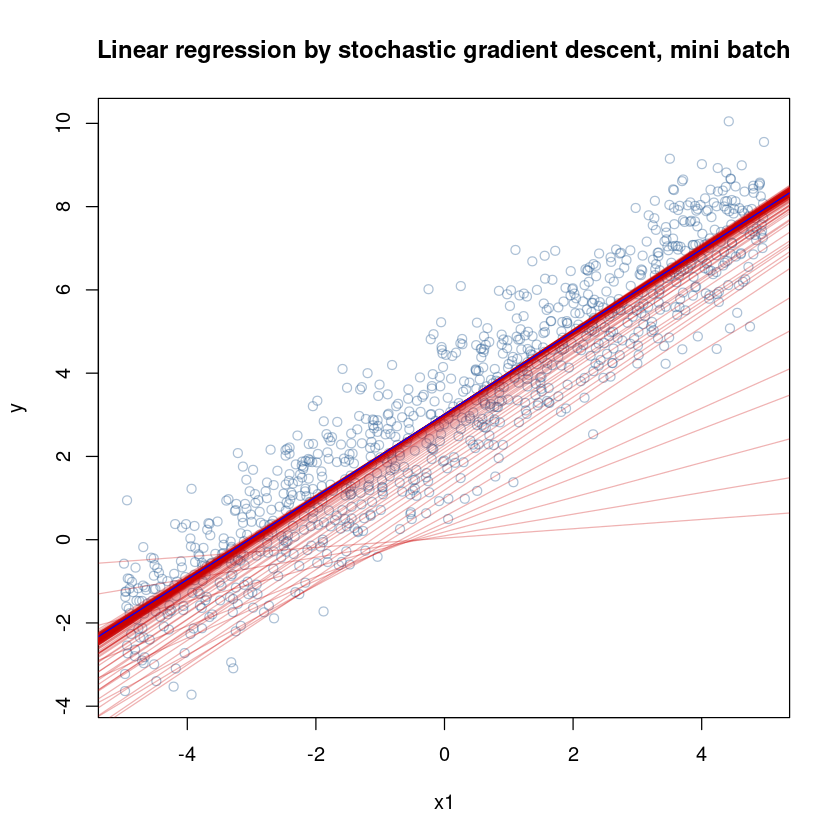

In [39]:
## plot data and converging fit
plot(x1, y, col = rgb(0.2, 0.4, 0.6, 0.4),
     main = "Linear regression by stochastic gradient descent, mini batch")
for (i in c(1, 3, 6, 10, 14, seq(20, niter, by = 10))) {
  abline(coef = theta_history[[i]], col = rgb(0.8, 0, 0, 0.3))
}
abline(coef = theta, col = "blue")

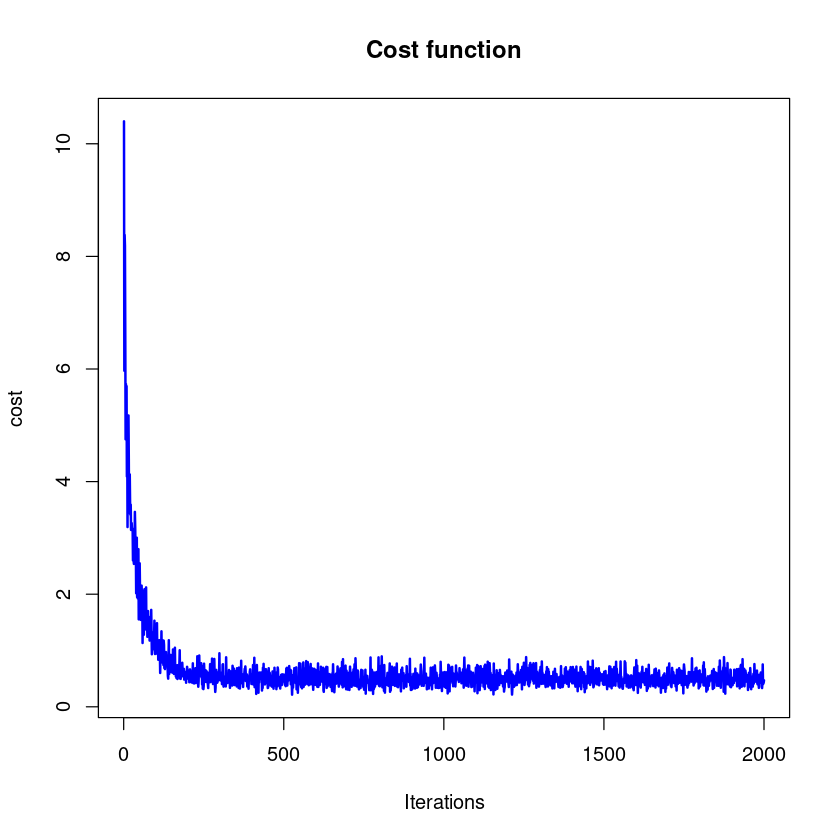

In [40]:
## cost convergence
plot(cost_history, type = "l", col = "blue", lwd = 2,
     main = "Cost function", ylab = "cost", xlab = "Iterations")

### Stochastic gradient descent, mini batch w/ multiple batches 

...